In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T


from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np


In [7]:
NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print_every = 100

print('using device:', device)

using device: cuda


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

def train(model, optimizer, epochs=1):
    Loss_list = []
    Accuracy_list = []
    model = model.to(device=device) 
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc,num_correct,num_samples = check_accuracy(loader_val, model)
                print()
        Loss_list.append(loss.item()) 
        Accuracy_list.append(100 * acc )
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() 
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))  
        return (acc,num_correct,num_samples)  

In [ ]:
model_ALLC = None
optimizer = None

from torch.nn import init

class ALLC(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(ALLC,self).__init__()
        
        self.conv1 = nn.Conv2d(input_size,96,3,padding=1)
        init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
        init.constant(self.conv1.bias, 0.1)
        
        self.conv2 = nn.Conv2d(96,96,3,padding=1)
        init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0))
        init.constant(self.conv2.bias, 0.1)
        
        self.conv3 = nn.Conv2d(96,96,3,padding=1,stride=2)
        init.xavier_uniform(self.conv3.weight, gain=np.sqrt(2.0))
        init.constant(self.conv3.bias, 0.1)
        
        self.conv4 = nn.Conv2d(96,192,3,padding=1)
        init.xavier_uniform(self.conv4.weight, gain=np.sqrt(2.0))
        init.constant(self.conv4.bias, 0.1)
        
        self.conv5 = nn.Conv2d(192,192,3,padding=1)
    
        
        self.conv6 = nn.Conv2d(192,192,3,padding=1,stride=2)

 
        self.conv7 = nn.Conv2d(192,192,3,padding=1)
        self.conv8 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)

        
    def forward(self,x):
        
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        
        conv3_out = F.dropout(conv3_out,0.5)
        
        conv4_out = F.relu(self.conv4(conv3_out)) 
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        
        conv6_out = F.dropout(conv6_out,0.5)
        
        conv7_out = F.relu(self.conv7(conv6_out)) 
        conv8_out = F.relu(self.conv8(conv7_out))
        class_out = F.relu(self.class_conv(conv8_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_ALLC = ALLC(3)
       
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ALLC.parameters(), lr=0.01,
                     momentum=0.9,weight_decay=0.001,nesterov=True)

train(model_ALLC, optimizer, epochs=20) 
check_accuracy(loader_test, model_ALLC.cuda())

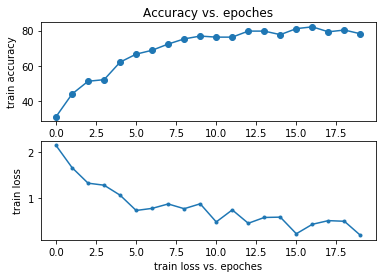

<Figure size 432x288 with 0 Axes>

In [89]:
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()


In [80]:
import pickle
import torch.utils.data as utils
from PIL import Image
from numpy import array
NUM_TRAIN = 4900

transform = T.Compose([
                T.ToPILImage(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
D = pickle.load(open('./subsets/class1/train','rb'),encoding='latin1')
reshape = np.vstack(D['data']).reshape(-1,3,32,32)
reshape_label = D['fine_labels']
train_data = torch.from_numpy(reshape)
train_data = train_data.type(torch.FloatTensor)
train_label = torch.from_numpy(array(reshape_label)) 

for i in range(5000):
    train_data[i] = transform(train_data[i]/255)
    
dataset = utils.TensorDataset(train_data,train_label)
loader_train = DataLoader(dataset,batch_size=100,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(dataset,batch_size=100,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,5000)))




In [81]:
D = pickle.load(open('./subsets/class1/test','rb'),encoding='latin1')
reshape = np.vstack(D['data']).reshape(-1,3,32,32)
reshape_label = D['fine_labels']
test_data = torch.from_numpy(reshape)
test_data = test_data.type(torch.FloatTensor)
test_label = torch.from_numpy(array(reshape_label)) 

for i in range(1000):
    test_data[i] = transform(test_data[i]/255)
    
dataset = utils.TensorDataset(test_data,test_label)
loader_test = DataLoader(dataset,batch_size=100)

In [116]:
load_model = model_ALLC
load_model_dict = load_model.state_dict()
#print(list(model.children()))
features = list(model.children())[0:8]
#print (features)
features.extend(([Flatten()]))
features.extend(([nn.Linear(420,10)]))


In [ ]:
''''def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
unpickle('./subsets/class2/train')'''

In [121]:
pretrained_dict = load_model_dict
model = nn.Sequential(*features)
model_dict = model.state_dict
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model = model.to(device=device)
optimizer = optim.SGD(model_ALLC.parameters(), lr=0.01,
                     momentum=0.9,weight_decay=0.001,nesterov=True)
train(model_ALLC, optimizer, epochs=20) 
check_accuracy(loader_test, model_ALLC.cuda())


TypeError: argument of type 'method' is not iterable